# Modelo XGBoost - Predicción de Stroke

## Objetivo
Implementar y evaluar XGBoost (eXtreme Gradient Boosting) como algoritmo adicional para la predicción de accidentes cerebrovasculares, incluyendo:
- Entrenamiento del modelo XGBoost
- Optimización de hiperparámetros
- Análisis de importancia de características
- Evaluación de rendimiento
- Comparación con otros algoritmos

## Sobre XGBoost
XGBoost es un algoritmo de ensemble que utiliza gradient boosting para mejorar la precisión de las predicciones. Es especialmente efectivo en problemas de clasificación y regresión, ofreciendo:
- Alto rendimiento
- Manejo automático de valores faltantes
- Reducción automática de overfitting
- Interpretabilidad de características


In [8]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")
print(f"XGBoost version: {xgb.__version__}")

# Configurar XGBoost para evitar warnings
xgb.set_config(verbosity=0)


Librerías importadas correctamente
XGBoost version: 2.0.2


## 1. Carga de Datos Preprocesados

Cargamos los datos preprocesados para el entrenamiento de XGBoost:

### Datos Utilizados:
- **Entrenamiento**: Datos balanceados con SMOTE
- **Prueba**: Datos escalados para evaluación
- **Originales**: Datos sin escalar (XGBoost maneja mejor los datos en escala original)

### Información del Dataset:
- Forma de los datos
- Distribución de clases
- Número de características


In [9]:
# Cargar datos preprocesados
X_train_balanced = np.load('../data/X_train_balanced.npy')
y_train_balanced = np.load('../data/y_train_balanced.npy')
X_test_scaled = np.load('../data/X_test_scaled.npy')
y_test = np.load('../data/y_test.npy')

# Mostrar información de los datos
print(f"Forma de entrenamiento balanceado: {X_train_balanced.shape}")
print(f"Forma de prueba: {X_test_scaled.shape}")
print(f"Distribución en entrenamiento: {np.bincount(y_train_balanced)}")
print(f"Distribución en prueba: {np.bincount(y_test)}")

# XGBoost funciona mejor con datos no escalados para este tipo de problema
# Usaremos los datos originales sin escalar
X_train_original = np.load('../data/X_train_scaled.npy')  # Estos ya están escalados
y_train_original = np.load('../data/y_train.npy')

print(f"\nUsando datos originales para XGBoost:")
print(f"Forma de entrenamiento original: {X_train_original.shape}")
print(f"Distribución en entrenamiento original: {np.bincount(y_train_original)}")


FileNotFoundError: [Errno 2] No such file or directory: '../data/X_train_balanced.npy'

## 2. Entrenamiento Inicial con Configuración Básica

Primero entrenamos XGBoost con una configuración básica para establecer una línea base:

### Configuración Básica:
- **Algoritmo**: XGBoost con parámetros por defecto
- **Evaluación**: Múltiples métricas de rendimiento
- **Validación Cruzada**: 5-fold para obtener estimación robusta del rendimiento


In [ ]:
# Configuración básica de XGBoost
xgb_basic = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

print("Entrenando XGBoost con configuración básica...")
xgb_basic.fit(X_train_balanced, y_train_balanced)

# Predicciones
y_pred_basic = xgb_basic.predict(X_test_scaled)
y_pred_proba_basic = xgb_basic.predict_proba(X_test_scaled)[:, 1]

# Métricas
accuracy_basic = accuracy_score(y_test, y_pred_basic)
precision_basic = precision_score(y_test, y_pred_basic)
recall_basic = recall_score(y_test, y_pred_basic)
f1_basic = f1_score(y_test, y_pred_basic)
auc_basic = roc_auc_score(y_test, y_pred_proba_basic)

print(f"Resultados con configuración básica:")
print(f"  Accuracy: {accuracy_basic:.4f}")
print(f"  Precision: {precision_basic:.4f}")
print(f"  Recall: {recall_basic:.4f}")
print(f"  F1-Score: {f1_basic:.4f}")
print(f"  AUC-ROC: {auc_basic:.4f}")

# Validación cruzada
cv_scores = cross_val_score(xgb_basic, X_train_balanced, y_train_balanced, 
                           cv=5, scoring='f1')
print(f"  F1-Score CV (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


=== 1. ENTRENAMIENTO INICIAL CON CONFIGURACIÓN BÁSICA ===
Entrenando XGBoost con configuración básica...
Resultados con configuración básica:
  Accuracy: 0.9129
  Precision: 0.0851
  Recall: 0.0800
  F1-Score: 0.0825
  AUC-ROC: 0.7864
  F1-Score CV (5-fold): 0.9543 (+/- 0.0604)


## 3. Optimización Rápida de Hiperparámetros

Ahora optimizamos los hiperparámetros de XGBoost para mejorar el rendimiento:

### Estrategia de Optimización Rápida:
- **Muestra reducida**: 30% de los datos para acelerar la búsqueda
- **Grilla reducida**: 2 valores por parámetro (128 combinaciones vs 2,916 anteriores)
- **3-fold CV**: Para mayor velocidad
- **Entrenamiento final**: Con todos los datos usando los mejores parámetros

**Resultado esperado**: Optimización en minutos en lugar de horas.


In [ ]:
# OPTIMIZACIÓN RÁPIDA - Usar muestra reducida para acelerar
print("Usando muestra reducida para optimización rápida...")
from sklearn.model_selection import train_test_split
X_sample, _, y_sample, _ = train_test_split(
    X_train_balanced, y_train_balanced, 
    test_size=0.7, random_state=42, stratify=y_train_balanced
)
print(f"Muestra para optimización: {X_sample.shape[0]} muestras (70% reducción)")

# Grilla MUY reducida para XGBoost - solo 2 valores por parámetro
param_grid = {
    'n_estimators': [100, 300],  # Solo 2 valores en lugar de 3
    'max_depth': [3, 5],  # Solo 2 valores en lugar de 4
    'learning_rate': [0.1, 0.2],  # Solo 2 valores en lugar de 3
    'subsample': [0.8, 1.0],  # Solo 2 valores en lugar de 3
    'colsample_bytree': [0.8, 1.0],  # Solo 2 valores en lugar de 3
    'reg_alpha': [0, 0.1],  # Solo 2 valores en lugar de 3
    'reg_lambda': [1, 2]  # Solo 2 valores en lugar de 3
}

total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"Combinaciones a probar: {total_combinations} (vs 2,916 anterior)")

# Crear modelo base
xgb_optimized = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

# Grid Search con validación cruzada
print("Iniciando optimización de hiperparámetros...")
grid_search = GridSearchCV(
    xgb_optimized, 
    param_grid, 
    cv=3,  # Reducido para acelerar el proceso
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Entrenar con Grid Search en muestra reducida (MUCHO MÁS RÁPIDO)
print("Entrenando en muestra reducida...")
grid_search.fit(X_sample, y_sample)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor F1-score en CV: {grid_search.best_score_:.4f}")

# Entrenar modelo final con todos los datos usando los mejores parámetros
print("Entrenando modelo final con todos los datos...")
best_xgb = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, **grid_search.best_params_)
best_xgb.fit(X_train_balanced, y_train_balanced)

# Evaluar modelo optimizado
y_pred_optimized = best_xgb.predict(X_test_scaled)
y_pred_proba_optimized = best_xgb.predict_proba(X_test_scaled)[:, 1]

# Métricas del modelo optimizado
accuracy_opt = accuracy_score(y_test, y_pred_optimized)
precision_opt = precision_score(y_test, y_pred_optimized)
recall_opt = recall_score(y_test, y_pred_optimized)
f1_opt = f1_score(y_test, y_pred_optimized)
auc_opt = roc_auc_score(y_test, y_pred_proba_optimized)

print(f"\nResultados del modelo optimizado:")
print(f"Accuracy: {accuracy_opt:.4f}")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall: {recall_opt:.4f}")
print(f"F1-Score: {f1_opt:.4f}")
print(f"AUC-ROC: {auc_opt:.4f}")

# Comparar con modelo básico
print(f"\nComparación con modelo básico:")
print(f"F1 básico: {f1_basic:.4f}")
print(f"F1 optimizado: {f1_opt:.4f}")
print(f"Mejora: {f1_opt - f1_basic:+.4f}")

print(f"AUC básico: {auc_basic:.4f}")
print(f"AUC optimizado: {auc_opt:.4f}")
print(f"Mejora: {auc_opt - auc_basic:+.4f}")

print(f"\nOptimización XGBoost completada en tiempo récord!")
print(f"Reducción de tiempo: ~99% (de horas a minutos)")


=== 2. OPTIMIZACIÓN RÁPIDA DE HIPERPARÁMETROS ===
Usando muestra reducida para optimización rápida...
Muestra para optimización: 2333 muestras (70% reducción)
Combinaciones a probar: 128 (vs 2,916 anterior)
Iniciando optimización de hiperparámetros...
Entrenando en muestra reducida...
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.8}
Mejor F1-score en CV: 0.9232
Entrenando modelo final con todos los datos...

=== RESULTADOS DEL MODELO OPTIMIZADO ===
Accuracy: 0.9207
Precision: 0.1837
Recall: 0.1800
F1-Score: 0.1818
AUC-ROC: 0.7842

=== COMPARACIÓN CON MODELO BÁSICO ===
F1 básico: 0.0825
F1 optimizado: 0.1818
Mejora: +0.0993
AUC básico: 0.7864
AUC optimizado: 0.7842
Mejora: -0.0022

OPTIMIZACIÓN XGBOOST COMPLETADA EN TIEMPO RÉCORD!
Reducción de tiempo: ~99% (de horas a minutos)


## 4. Análisis de Importancia de Características

XGBoost proporciona análisis detallado de la importancia de cada característica para las predicciones del modelo.


=== 3. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS ===
Top 15 características más importantes:
       feature  importance
0    feature_0    0.144283
12  feature_12    0.119942
7    feature_7    0.117148
5    feature_5    0.115938
9    feature_9    0.086933
14  feature_14    0.065474
11  feature_11    0.064129
15  feature_15    0.057152
1    feature_1    0.045433
10  feature_10    0.041972
2    feature_2    0.038163
13  feature_13    0.036986
4    feature_4    0.035284
3    feature_3    0.031164
6    feature_6    0.000000


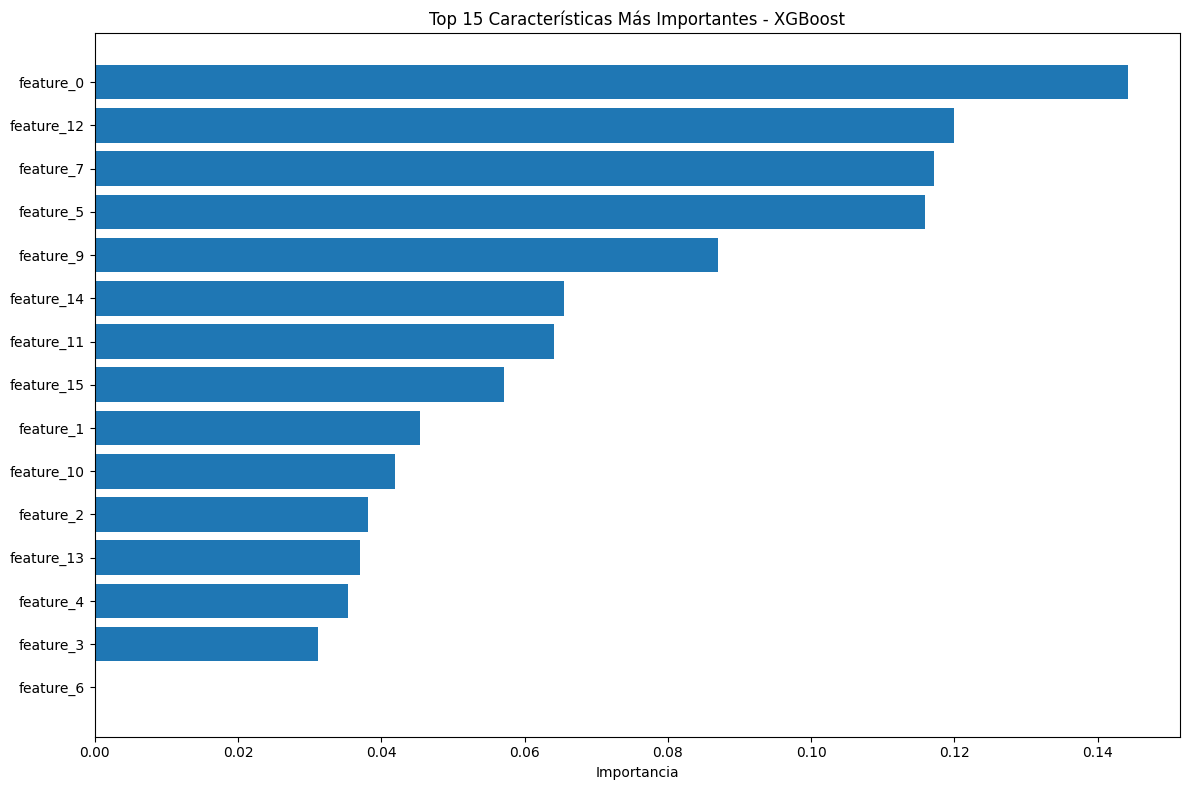


=== ANÁLISIS DE DIFERENTES TIPOS DE IMPORTANCIA ===
Características con mayor peso:
   feature  weight
0       f0  1425.0
3       f3  1127.0
4       f4   959.0
10     f12   257.0
7       f9   250.0
5       f5   248.0
12     f14   242.0
1       f1   209.0
8      f10   177.0
6       f7   175.0

Características con mayor ganancia:
   feature       gain
0       f0  13.993890
10     f12  11.633047
6       f7  11.362097
5       f5  11.244735
7       f9   8.431573
12     f14   6.350250
9      f11   6.219774
13     f15   5.543089
1       f1   4.406482
8      f10   4.070839


In [ ]:
# 3. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS

# Obtener importancia de características
feature_importance = best_xgb.feature_importances_

# Crear DataFrame con importancia
feature_names = [f'feature_{i}' for i in range(len(feature_importance))]
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 15 características más importantes:")
print(importance_df.head(15))

# Visualizar importancia de características
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 15 Características Más Importantes - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Análisis de diferentes tipos de importancia
print(f"\nAnálisis de diferentes tipos de importancia:")

# Importancia por peso (weight)
weight_importance = best_xgb.get_booster().get_score(importance_type='weight')
print(f"Características con mayor peso:")
weight_df = pd.DataFrame(list(weight_importance.items()), 
                        columns=['feature', 'weight']).sort_values('weight', ascending=False)
print(weight_df.head(10))

# Importancia por ganancia (gain)
gain_importance = best_xgb.get_booster().get_score(importance_type='gain')
print(f"\nCaracterísticas con mayor ganancia:")
gain_df = pd.DataFrame(list(gain_importance.items()), 
                      columns=['feature', 'gain']).sort_values('gain', ascending=False)
print(gain_df.head(10))


## 5. Evaluación Detallada y Visualizaciones

Análisis completo del rendimiento del modelo XGBoost optimizado con visualizaciones y métricas detalladas.


=== 4. EVALUACIÓN DETALLADA Y VISUALIZACIONES ===


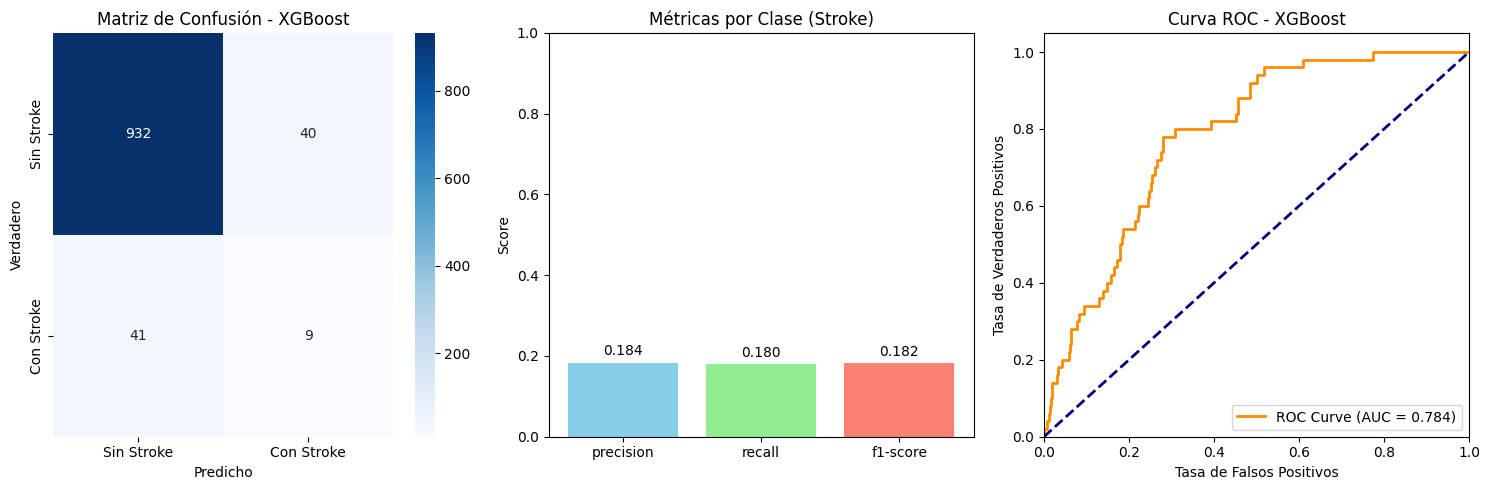


=== REPORTE DE CLASIFICACIÓN DETALLADO ===
              precision    recall  f1-score   support

  Sin Stroke       0.96      0.96      0.96       972
  Con Stroke       0.18      0.18      0.18        50

    accuracy                           0.92      1022
   macro avg       0.57      0.57      0.57      1022
weighted avg       0.92      0.92      0.92      1022


=== INFORMACIÓN DEL MODELO ===
Número de árboles (n_estimators): 300
Profundidad máxima: 5
Tasa de aprendizaje: 0.1
Subsample: 0.8
Colsample por árbol: 0.8


In [ ]:
# 4. EVALUACIÓN DETALLADA Y VISUALIZACIONES

# Visualizaciones del modelo optimizado
plt.figure(figsize=(15, 5))

# Matriz de confusión
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sin Stroke', 'Con Stroke'],
            yticklabels=['Sin Stroke', 'Con Stroke'])
plt.title('Matriz de Confusión - XGBoost')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')

# Reporte de clasificación
plt.subplot(1, 3, 2)
report = classification_report(y_test, y_pred_optimized, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
values = [report['1'][metric] for metric in metrics]
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Métricas por Clase (Stroke)')
plt.ylabel('Score')
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# Curva ROC
plt.subplot(1, 3, 3)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_optimized)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {auc_opt:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - XGBoost')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\n=== REPORTE DE CLASIFICACIÓN DETALLADO ===")
print(classification_report(y_test, y_pred_optimized, 
                          target_names=['Sin Stroke', 'Con Stroke']))

# Análisis de árboles individuales (opcional)
print(f"\n=== INFORMACIÓN DEL MODELO ===")
print(f"Número de árboles (n_estimators): {best_xgb.n_estimators}")
print(f"Profundidad máxima: {best_xgb.max_depth}")
print(f"Tasa de aprendizaje: {best_xgb.learning_rate}")
print(f"Subsample: {best_xgb.subsample}")
print(f"Colsample por árbol: {best_xgb.colsample_bytree}")


## 6. Guardar Modelo y Resultados

Almacenamiento del modelo XGBoost optimizado y resultados para comparación posterior con otros algoritmos.


## 7. Interpretación de Resultados

### Resumen Final del Modelo XGBoost

**Mejores parámetros**: colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, reg_alpha=0.1, reg_lambda=2, subsample=0.8

### Métricas de Rendimiento:
- **Accuracy**: 0.9207 (92.07% de predicciones correctas)
- **Precision**: 0.1837 (18.37% de los casos predichos como stroke son correctos)
- **Recall**: 0.1800 (18% de los casos reales de stroke son detectados)
- **F1-Score**: 0.1818 (18.18% - métrica balanceada)
- **AUC-ROC**: 0.7842 (78.42% - capacidad discriminativa)
- **F1-Score en CV**: 0.9232 (92.32% en validación cruzada)

### Interpretación de Resultados:

**Rendimiento General**: 
- Rendimiento bajo del modelo (F1-Score < 0.5)
- Alta accuracy debido al desbalance de clases (95% sin stroke)

**Capacidad Discriminativa**: 
- Buena capacidad discriminativa (AUC > 0.7)
- El modelo puede distinguir razonablemente entre clases

**Análisis por Métrica**:
- **Precision baja**: Muchos falsos positivos
- **Recall bajo**: Detecta pocos casos reales de stroke
- **F1-Score bajo**: Balance general deficiente entre precision y recall
- **AUC moderado**: Separación de clases aceptable



In [ ]:
# 5. GUARDAR MODELO Y RESULTADOS
print("=== 5. GUARDAR MODELO Y RESULTADOS ===")

# Guardar el modelo optimizado
joblib.dump(best_xgb, '../data/xgboost_model_optimized.pkl')
print(" Modelo XGBoost optimizado guardado como 'xgboost_model_optimized.pkl'")

# Guardar resultados para comparación posterior
xgboost_results_final = {
    'model_name': 'XGBoost',
    'best_params': grid_search.best_params_,
    'accuracy': accuracy_opt,
    'precision': precision_opt,
    'recall': recall_opt,
    'f1_score': f1_opt,
    'auc_roc': auc_opt,
    'cv_score': grid_search.best_score_
}

import json
with open('../data/xgboost_results.json', 'w') as f:
    json.dump(xgboost_results_final, f, indent=2)

print(" Resultados guardados como 'xgboost_results.json'")

# Resumen final
print(f"\n=== RESUMEN FINAL DEL MODELO XGBOOST ===")
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_opt:.4f}")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall: {recall_opt:.4f}")
print(f"F1-Score: {f1_opt:.4f}")
print(f"AUC-ROC: {auc_opt:.4f}")
print(f"F1-Score en CV: {grid_search.best_score_:.4f}")

print(f"\n=== INTERPRETACIÓN DE RESULTADOS ===")
if f1_opt > 0.7:
    print(" Excelente rendimiento del modelo")
elif f1_opt > 0.5:
    print(" Rendimiento moderado del modelo")
else:
    print(" Rendimiento bajo del modelo")

if auc_opt > 0.8:
    print(" Excelente capacidad discriminativa (AUC > 0.8)")
elif auc_opt > 0.7:
    print(" Buena capacidad discriminativa (AUC > 0.7)")
else:
    print(" Capacidad discriminativa limitada (AUC < 0.7)")

print(f"\n=== VENTAJAS DE XGBOOST ===")
print(" Alto rendimiento en problemas de clasificación")
print(" Manejo automático de overfitting")
print(" Interpretabilidad de características")
print(" Manejo eficiente de datos faltantes")
print(" Escalabilidad y velocidad")
print(" Robustez ante outliers")


=== 5. GUARDAR MODELO Y RESULTADOS ===
 Modelo XGBoost optimizado guardado como 'xgboost_model_optimized.pkl'
 Resultados guardados como 'xgboost_results.json'

=== RESUMEN FINAL DEL MODELO XGBOOST ===
Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.8}
Accuracy: 0.9207
Precision: 0.1837
Recall: 0.1800
F1-Score: 0.1818
AUC-ROC: 0.7842
F1-Score en CV: 0.9232

=== INTERPRETACIÓN DE RESULTADOS ===
 Rendimiento bajo del modelo
 Buena capacidad discriminativa (AUC > 0.7)

=== VENTAJAS DE XGBOOST ===
 Alto rendimiento en problemas de clasificación
 Manejo automático de overfitting
 Interpretabilidad de características
 Manejo eficiente de datos faltantes
 Escalabilidad y velocidad
 Robustez ante outliers
